In [1]:
import xarray as xr
import rioxarray



In [2]:
# 1) Abrir dataset
ghi = xr.open_zarr("/home/aninotna/magister/tesis/justh2_pipeline/data/solar/solar_diario_grilla.zarr")
print("Variables:", list(ghi.data_vars))

Variables: ['cloud', 'temp', 'vel', 'dni', 'ghi']


In [3]:
# 2) Seleccionar SOLO la variable GHI
ghi_da = ghi["ghi"]
print("\nGHI DataArray:")
print(ghi_da)


GHI DataArray:
<xarray.DataArray 'ghi' (date: 4748, lat: 20, lon: 20)> Size: 15MB
dask.array<open_dataset-ghi, shape=(4748, 20, 20), dtype=float64, chunksize=(1187, 5, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 160B -33.23 -33.17 -33.12 ... -32.38 -32.33 -32.27
  * lon      (lon) float64 160B -71.88 -71.83 -71.72 ... -70.22 -70.12 -70.03
  * date     (date) datetime64[ns] 38kB 2004-01-01 2004-01-02 ... 2016-12-30


In [4]:
# 3) Promedio temporal
ghi_mean = ghi_da.mean(dim="date")
print("\nGHI mean (promedio temporal):")
print(ghi_mean)
print("Shape:", ghi_mean.shape)
print("Min:", float(ghi_mean.min()), "Max:", float(ghi_mean.max()))
print("Dims:", ghi_mean.dims)


GHI mean (promedio temporal):
<xarray.DataArray 'ghi' (lat: 20, lon: 20)> Size: 3kB
dask.array<mean_agg-aggregate, shape=(20, 20), dtype=float64, chunksize=(5, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 160B -33.23 -33.17 -33.12 ... -32.38 -32.33 -32.27
  * lon      (lon) float64 160B -71.88 -71.83 -71.72 ... -70.22 -70.12 -70.03
Shape: (20, 20)
Min: 177.31997558319293 Max: 250.58090184092183
Dims: ('lat', 'lon')


In [5]:
# 4) Renombrar dims lat/lon → y/x
ghi_mean = ghi_mean.rename({"lat": "y", "lon": "x"})

# 5) Añadir CRS y setear dims espaciales
ghi_mean = ghi_mean.rio.write_crs("EPSG:4326")
ghi_mean = ghi_mean.rio.set_spatial_dims(x_dim="x", y_dim="y")

# 6) Exportar a GeoTIFF
ghi_mean.rio.to_raster("ghi_mean.tif")
print("\n✅ Exportado a ghi_mean.tif")


✅ Exportado a ghi_mean.tif


El siguiente paso es usarlo para enriquecer los polígonos (pv_patches.shp) con el valor medio de GHI dentro de cada parche.

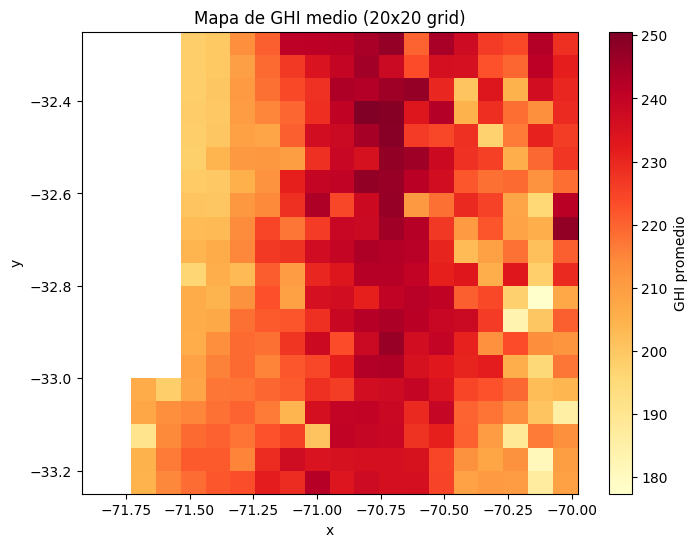

In [27]:
import rioxarray
import matplotlib.pyplot as plt

# 1) Abrir raster
ghi_mean = rioxarray.open_rasterio("ghi_mean.tif").squeeze()

# 2) Graficar
fig, ax = plt.subplots(figsize=(8,6))
ghi_mean.plot(ax=ax, cmap="YlOrRd", cbar_kwargs={"label": "GHI promedio"})
ax.set_title("Mapa de GHI medio (20x20 grid)")
plt.show()


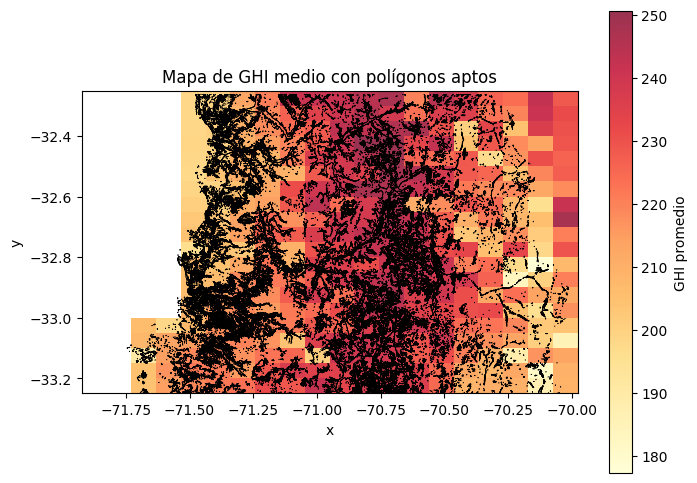

In [28]:
import geopandas as gpd

gdf = gpd.read_file("pv_patches.shp").to_crs(ghi_mean.rio.crs)

fig, ax = plt.subplots(figsize=(8,6))
ghi_mean.plot(ax=ax, cmap="YlOrRd", alpha=0.8, cbar_kwargs={"label": "GHI promedio"})
gdf.boundary.plot(ax=ax, color="black", linewidth=0.5)
ax.set_title("Mapa de GHI medio con polígonos aptos")
plt.show()


In [29]:
import rasterio
import geopandas as gpd

gdf = gpd.read_file("pv_patches.shp").to_crs("EPSG:4326")

vals = []
with rasterio.open("ghi_mean.tif") as src:
    band = src.read(1)
    for geom in gdf.geometry:
        lon, lat = geom.centroid.x, geom.centroid.y
        try:
            row, col = src.index(lon, lat)
            val = band[row, col]
        except IndexError:
            val = None
        vals.append(val)

gdf["ghi_mean"] = vals
print(gdf[["area_ha", "ghi_mean"]].head())


    area_ha    ghi_mean
0  1.106206  237.541611
1  2.138666  237.541611
2  3.318619  226.410034
3  1.622436  226.410034
4  1.327448  244.417343


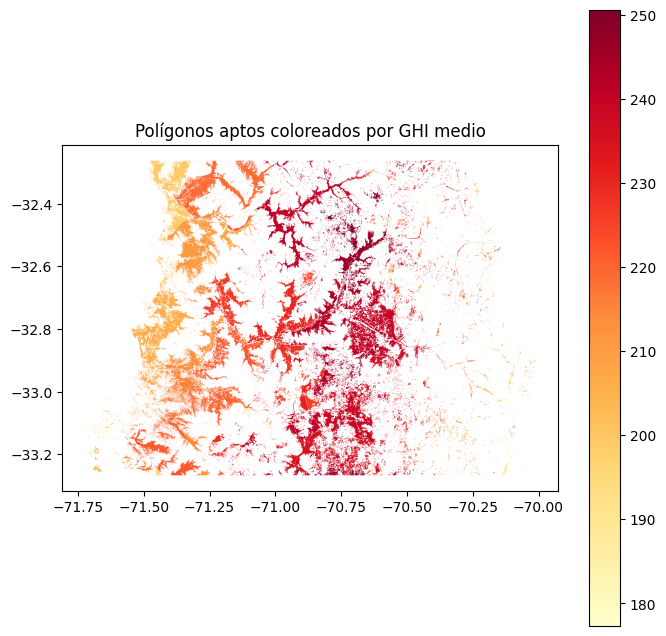

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax,
         column="ghi_mean",
         cmap="YlOrRd",
         legend=True,
         linewidth=0.3)

ax.set_title("Polígonos aptos coloreados por GHI medio")
plt.show()


Polígonos totales: 15483
Polígonos con GHI >= 230: 6937


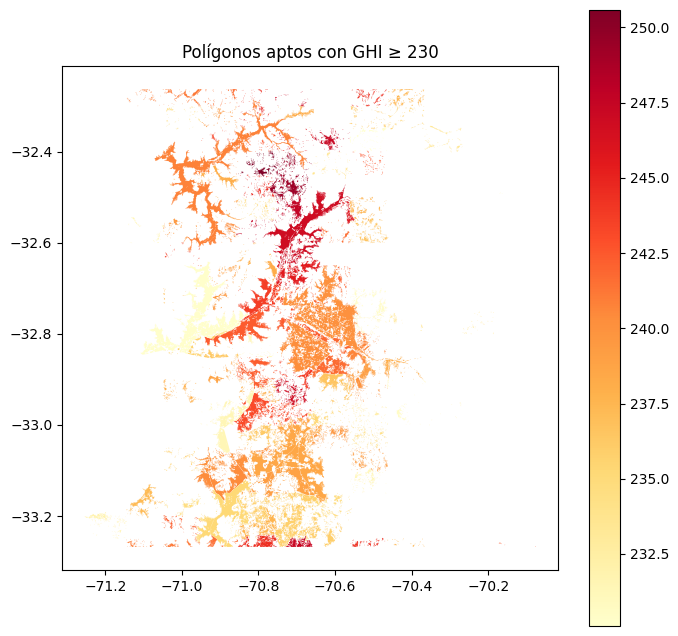

In [34]:
# Filtrar
gdf_high_ghi = gdf[gdf["ghi_mean"] >= 230]

print("Polígonos totales:", len(gdf))
print("Polígonos con GHI >= 230:", len(gdf_high_ghi))

# Graficar
fig, ax = plt.subplots(figsize=(8,8))
gdf_high_ghi.plot(ax=ax, column="ghi_mean", cmap="YlOrRd", legend=True, linewidth=0.3)
ax.set_title("Polígonos aptos con GHI ≥ 230")
plt.show()


In [35]:
gdf_high_ghi = gdf[gdf["ghi_mean"] >= 230]  # ejemplo de umbral

In [38]:
DENSITY_MW_PER_KM2 = 60.0  # MW por km²

In [39]:
# Asegurar que tienes área en km²
gdf_high_ghi["area_km2"] = gdf_high_ghi["area_ha"] / 100

# Calcular energy_cap_max para cada polígono
gdf_high_ghi["energy_cap_max_MW"] = gdf_high_ghi["area_km2"] * DENSITY_MW_PER_KM2

# Ver los 5 polígonos con mayor potencial
print(gdf_high_ghi[["area_ha", "ghi_mean", "energy_cap_max_MW"]]
      .sort_values("energy_cap_max_MW", ascending=False)
      .head())


            area_ha    ghi_mean  energy_cap_max_MW
4565   12911.567077  240.774002        7746.940246
7323   10460.656229  230.194534        6276.393738
7270   10246.568422  240.080750        6147.941053
13618   9407.547759  238.537384        5644.528656
7730    5912.673081  240.302032        3547.603849


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/tmp/ipykernel_1024971/796702363.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_1024971/796702363.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


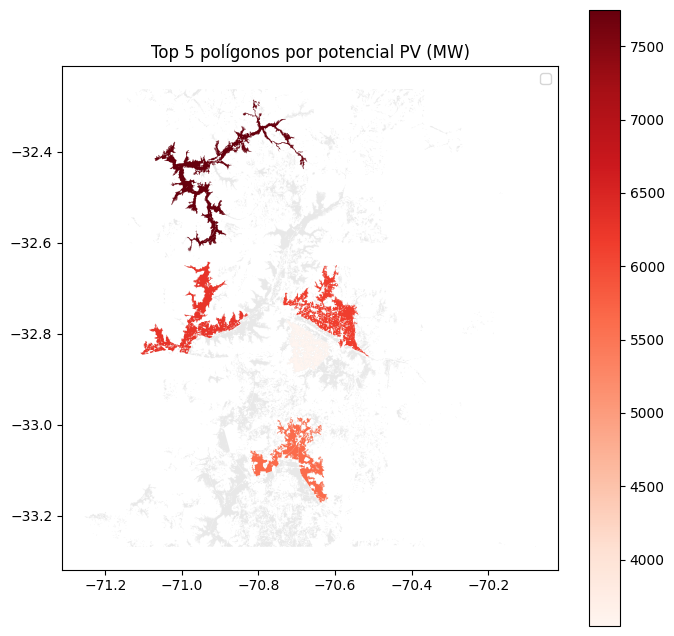

In [41]:
import matplotlib.pyplot as plt

# Ordenar por energy_cap_max y quedarte con top 5
top5 = gdf_high_ghi.sort_values("energy_cap_max_MW", ascending=False).head(5)

# Graficar
fig, ax = plt.subplots(figsize=(8,8))
gdf_high_ghi.plot(ax=ax, color="lightgrey", alpha=0.5, label="Otros polígonos")
top5.plot(ax=ax, column="energy_cap_max_MW", cmap="Reds", legend=True)

ax.set_title("Top 5 polígonos por potencial PV (MW)")
ax.legend()
plt.show()
